# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

Yelp Review Polarity Dataset


ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 2 columns in them, corresponding to class index (1 and 2) and review text. The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".


2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [2]:
train_df = pd.read_csv("/kaggle/input/yelpreviewpolaritydataset/train.csv", header=None, escapechar='\\', quotechar='"', on_bad_lines='skip')
#train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True) #drop half dataset
#train_df = pd.read_csv("/kaggle/input/yelpreviewpolaritydataset/test.csv", header=None, escapechar='\\', quotechar='"', on_bad_lines='skip')
test_df = pd.read_csv("/kaggle/input/yelpreviewpolaritydataset/test.csv", header=None, escapechar='\\', quotechar='"', on_bad_lines='skip')

In [3]:
def clean_and_tokenize(text: str) -> list:
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return [token for token in tokens if token not in STOPWORDS and token != '']

In [4]:
custom_stopwords = {
    'yelp', 'restaurant', 'place', 'food', 'order', 'ordered', 'service', 'got', 
    'get', 'came', 'go', 'going', 'back', 'thing', 'things', 'one', 'two',
    'also', 'would', 'really', 'like', 'just', 'even', 'still', 'time', 
    'us', 'went', 'see', 'say', 'said', 'did', 'dont', 'didnt', 'im', 'ive',
    'cant', 'couldnt', 'wasnt', 'isnt', 'youre', 'youve', 'theyre', 'thats'
}

nltk.download('stopwords')
nltk.download('punkt')
STOPWORDS = set(stopwords.words('english')).union(custom_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
print("Sample stopwords: ", STOPWORDS)

Sample stopwords:  {"won't", 'the', 'got', 'his', 'to', 'one', 'still', "shan't", 'do', 'restaurant', 'off', 've', 'thats', 'here', 'just', 'ours', 'their', 'why', 'o', 'going', 'theyre', 'further', 'all', "aren't", "needn't", 'me', "mightn't", 'itself', "they've", 'wasnt', 'youve', 'its', "you'd", 'mightn', 'am', 'can', 'ma', 'there', 'more', 'myself', 'food', 'other', 't', "they'll", 'during', 'went', 'a', 'that', 'be', 'by', 'hers', 'no', 'our', 'any', "we've", 'nor', 'thing', 'even', 'it', 'hasn', 'shan', 'them', 'couldnt', 'each', 'had', 'how', 'once', 'for', "they'd", 'up', "isn't", 'been', 'and', 'yourselves', 'ain', 'haven', 'as', 'because', 'but', 'would', "we're", 'your', 'between', "i'd", 'some', "hasn't", 'where', "she'd", 'hadn', 'while', "hadn't", 'if', 'themselves', 'this', 'see', "wouldn't", 'mustn', 'order', 'what', 'down', 'again', "haven't", 'didn', 'these', 'are', "it'll", 'ordered', "that'll", 'ourselves', "you've", 'they', 'd', "she'll", 'when', 'have', 'we', 'wou

In [6]:
label_mapping = {1: 0, 2: 1}
all_reviews = []    
all_labels = []
all_raw_texts = []  

df = train_df.dropna()
for _, row in df.iterrows():
    orig_label = row[0]
    new_label = label_mapping.get(orig_label)
    if new_label is None:
        continue
    review_text = row[1]
    tokens = clean_and_tokenize(review_text)
    if tokens:
        all_reviews.append(tokens)
        all_labels.append(new_label)
        all_raw_texts.append(review_text)

In [7]:
print(f"Total reviews loaded: {len(all_reviews)}")
max_tokens = max(len(tokens) for tokens in all_reviews)
print(f"Maximum number of tokens in any review: {max_tokens}")

max_chars = max(len(text) for text in all_raw_texts)
print(f"Maximum number of characters in any review: {max_chars}")

Total reviews loaded: 481359
Maximum number of tokens in any review: 665
Maximum number of characters in any review: 5195


In [8]:
n = next((i for i, label in enumerate(all_labels) if label == 0), None)
p = next((i for i, label in enumerate(all_labels) if label == 1), None)

In [9]:
print("Sample Positive token: ", all_reviews[p], "\nLabel: ", all_labels[p], "\nRaw text: ", all_raw_texts[p])

Sample Positive token:  ['dr', 'goldberg', '10', 'years', 'think', '1st', 'patients', 'started', 'mhmg', 'hes', 'great', 'years', 'big', 'picture', 'former', 'gyn', 'dr', 'markoff', 'found', 'fibroids', 'explores', 'options', 'patient', 'understanding', 'doesnt', 'judge', 'asks', 'right', 'questions', 'thorough', 'wants', 'kept', 'loop', 'every', 'aspect', 'medical', 'health', 'life'] 
Label:  1 
Raw text:  Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.


In [10]:
print("Sample Negative token: ", all_reviews[n], "\nLabel: ", all_labels[n], "\nRaw text: ", all_raw_texts[n])

Sample Negative token:  ['unfortunately', 'frustration', 'dr', 'goldbergs', 'patient', 'repeat', 'experience', 'many', 'doctors', 'nyc', 'good', 'doctor', 'terrible', 'staff', 'seems', 'staff', 'simply', 'never', 'answers', 'phone', 'usually', 'takes', '2', 'hours', 'repeated', 'calling', 'answer', 'wants', 'deal', 'run', 'problem', 'many', 'doctors', 'office', 'workers', 'patients', 'medical', 'needs', 'anyone', 'answering', 'phone', 'incomprehensible', 'work', 'aggravation', 'regret', 'feel', 'give', 'dr', 'goldberg', '2', 'stars'] 
Label:  0 
Raw text:  Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office wor

In [11]:
def build_vocab(token_lists: list) -> dict:
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for tokens in token_lists:
        for token in tokens:
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

vocab = build_vocab(all_reviews)
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 562200


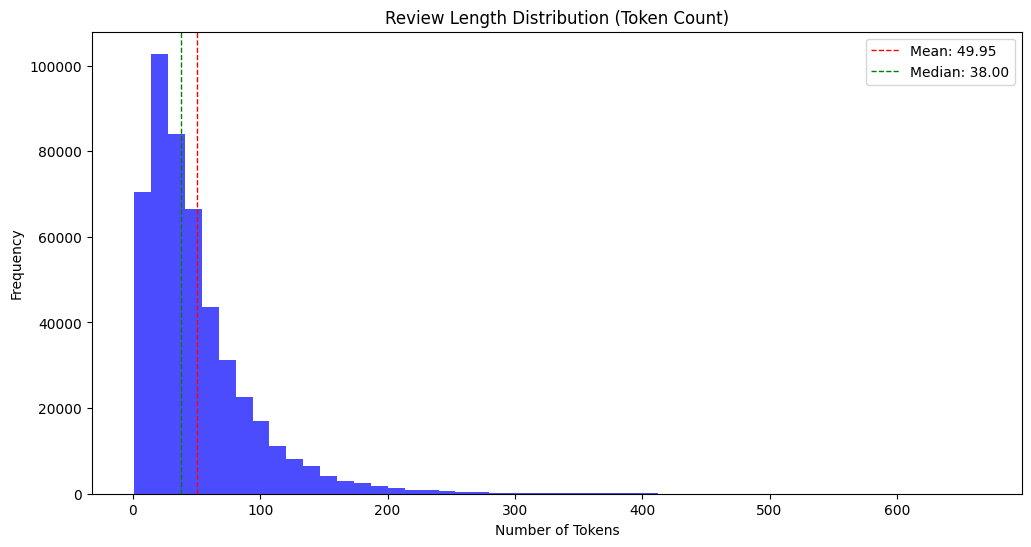

In [12]:
review_lengths = [len(tokens) for tokens in all_reviews]
plt.figure(figsize=(12, 6))
plt.hist(review_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Review Length Distribution (Token Count)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.legend()
plt.show()

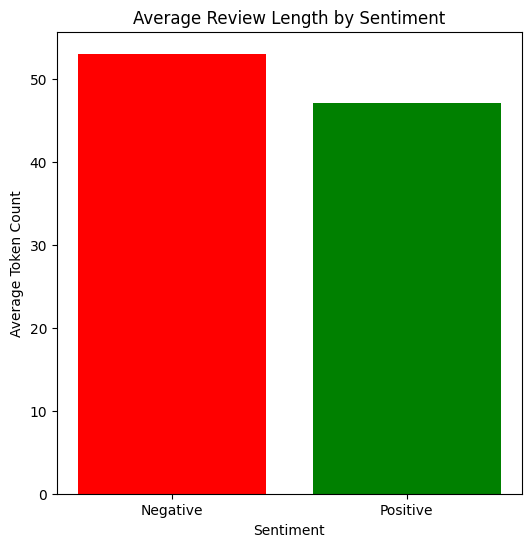

In [13]:
lengths_by_label = [(len(tokens), label) for tokens, label in zip(all_reviews, all_labels)]
neg_lengths = [length for length, lbl in lengths_by_label if lbl == 0]
pos_lengths = [length for length, lbl in lengths_by_label if lbl == 1]
plt.figure(figsize=(6, 6))
plt.bar(['Negative', 'Positive'], [np.mean(neg_lengths), np.mean(pos_lengths)], color=['red', 'green'])
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Token Count')
plt.show()

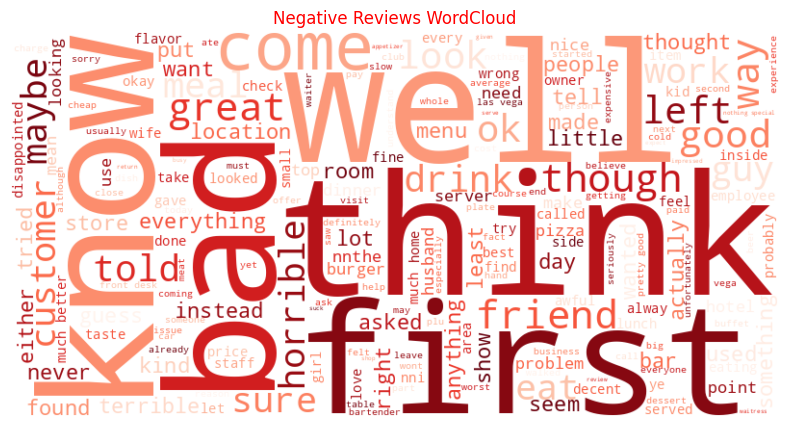

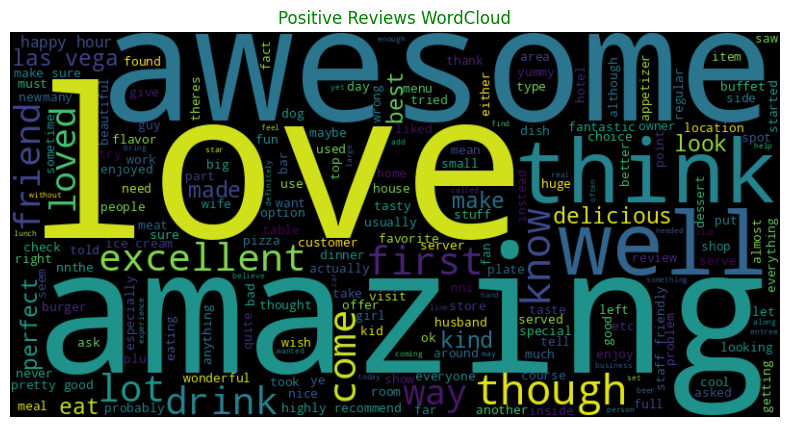

In [14]:
neg_tokens = [token for tokens, lbl in zip(all_reviews, all_labels) if lbl == 0 for token in tokens]
pos_tokens = [token for tokens, lbl in zip(all_reviews, all_labels) if lbl == 1 for token in tokens]

wc_neg = WordCloud(width=800, height=400, background_color='white', colormap="Reds").generate(" ".join(neg_tokens))
wc_pos = WordCloud(width=800, height=400, background_color='black').generate(" ".join(pos_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Reviews WordCloud', color='red')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Reviews WordCloud', color='green')
plt.show()

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [15]:
seq_length = 100
encoded_reviews = []

for tokens in all_reviews:
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(token_ids) >= seq_length:
        token_ids = token_ids[:seq_length]
    else:
        token_ids = token_ids + [vocab['<PAD>']] * (seq_length - len(token_ids))
    encoded_reviews.append(token_ids)

In [16]:
print("Sample Encoded Review: ", encoded_reviews[0])

Sample Encoded Review:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 9, 10, 32, 33, 34, 35, 36, 37, 38, 20, 39, 40, 41, 42, 43, 44, 4, 45, 23, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
label_mapping = {1: 0, 2: 1}
test_all_reviews = []    
test_all_labels = []
test_all_raw_texts = []  

df = test_df.dropna()
for _, row in df.iterrows():
    orig_label = row[0]
    new_label = label_mapping.get(orig_label)
    if new_label is None:
        continue
    review_text = row[1]
    tokens = clean_and_tokenize(review_text)
    if tokens:
        test_all_reviews.append(tokens)
        test_all_labels.append(new_label)
        test_all_raw_texts.append(review_text)

In [18]:
print(f"Total Test reviews loaded: {len(test_all_reviews)}")
test_max_tokens = max(len(tokens) for tokens in test_all_reviews)
print(f"Maximum number of tokens in any Test review: {test_max_tokens}")

test_max_chars = max(len(text) for text in test_all_raw_texts)
print(f"Maximum number of characters in any Test review: {test_max_chars}")

Total Test reviews loaded: 32357
Maximum number of tokens in any Test review: 510
Maximum number of characters in any Test review: 5016


In [19]:
test_encoded_reviews = []

for tokens in test_all_reviews:
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(token_ids) >= seq_length:
        token_ids = token_ids[:seq_length]
    else:
        token_ids = token_ids + [vocab['<PAD>']] * (seq_length - len(token_ids))
    test_encoded_reviews.append(token_ids)

## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=500):
        super(PositionalEncoding, self).__init__()

        positional_encoding = torch.zeros(max_len, embedding_dim)
        position_indices = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        frequency_terms = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))

        positional_encoding[:, 0::2] = torch.sin(position_indices * frequency_terms)
        positional_encoding[:, 1::2] = torch.cos(position_indices * frequency_terms)

        positional_encoding = positional_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_encoding', positional_encoding)

    def forward(self, x):
        return x + self.pos_encoding[:x.size(0), :]

2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_encoder_layers, feedforward_dim, 
                 max_seq_length, num_classes, device, dropout=0.1 ):
        super(TransformerTextClassifier, self).__init__()
        
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.position_encoding = PositionalEncoding(embedding_dim, max_seq_length).to(device)
        self.dropout_layer = nn.Dropout(p=dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=feedforward_dim,
            dropout=dropout
        ).to(device)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers).to(device)
        self.output_projection = nn.Linear(embedding_dim, num_classes).to(device)
        self.embedding_dim = embedding_dim

    def forward(self, input_ids):
        input_ids = input_ids.to(self.device)

        embedded_tokens = self.embedding(input_ids) * math.sqrt(self.embedding_dim) 
        embedded_tokens = self.position_encoding(embedded_tokens)
        embedded_tokens = self.dropout_layer(embedded_tokens)

        encoder_input = embedded_tokens.transpose(0, 1)
        encoder_output = self.encoder(encoder_input)
        encoder_output = encoder_output.transpose(0, 1)

        pooled_output = encoder_output.mean(dim=1)
        pooled_output = self.dropout_layer(pooled_output)

        logits = self.output_projection(pooled_output)
        return F.log_softmax(logits, dim=-1)

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [22]:
## No Decoder used for this classification task.

4.	Print model summary using torchinfo.summary

In [23]:
vocab_size = len(vocab)
num_output_classes = len(set(all_labels))
print(f"Vocabulary Size: {vocab_size}")
print(f"Number of Classes: {num_output_classes}")

Vocabulary Size: 562200
Number of Classes: 2


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 128              
num_attention_heads = 8        
num_encoder_layers = 6           
feedforward_hidden_dim = 2048    
sequence_length = seq_length             

base_model = TransformerTextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_attention_heads,
    num_encoder_layers=num_encoder_layers,
    feedforward_dim=feedforward_hidden_dim,
    max_seq_length=sequence_length,
    num_classes=num_output_classes,
    device=device,
    dropout=0
).to(device)

print("Model Summary:")
print(base_model)

Model Summary:
TransformerTextClassifier(
  (embedding): Embedding(562200, 128)
  (position_encoding): PositionalEncoding()
  (dropout_layer): Dropout(p=0, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (output_projection): Linear(in_features=128, out_features=2, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


5. Briefly describe the Transformer architecture you have defined.

<span style='color:green'>The defined architecture is an encoder-only Transformer tailored for classification tasks. Here’s a brief breakdown:

Embedding & Scaling:
The input token IDs are first transformed by an embedding layer that maps each token to a d_model-dimensional vector. These embeddings are scaled by the square root of d_model to stabilize learning.

Positional Encoding:
A custom positional encoding is added to the embeddings. The PositionEncoding class computes sine and cosine functions of varying frequencies that are added to the embeddings to inject positional information, enabling the model to capture the order of tokens.

Dropout Regularization:
Dropout layers are applied throughout the model to help prevent overfitting. Dropout is applied right after positional encoding, after the Transformer encoder, and again before the final pooling.

Transformer Encoder:
The core of the model is built using PyTorch's nn.TransformerEncoder, which stacks multiple instances of nn.TransformerEncoderLayer. Each encoder layer includes:

A multi-head self-attention mechanism that allows every token to attend to all others,

A feed-forward network for transforming the attention output,

Internal normalization and residual connections to ensure stable gradients and improve training.

Pooling & Output:
After encoding, the per-token representations (across the sequence) are averaged (mean pooling) to aggregate the sequence information into a single fixed-size vector. This pooled representation is passed through a final linear layer that maps it to the number of target classes. The output is then processed using log_softmax for classification, which produces log-probabilities for each class.

In summary, the model leverages a Transformer encoder with dropout for robust feature extraction from input text, followed by pooling and a linear classification layer, making it well-suited for sentiment or other classification tasks without using a decoder component.</span>

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [25]:
from sklearn.model_selection import train_test_split

inputs_tensor = torch.tensor(encoded_reviews, dtype=torch.long)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)

LIMIT = int(len(inputs_tensor) * 0.5)
X = inputs_tensor[:LIMIT]
y = labels_tensor[:LIMIT]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

print(f"Train Dataset shape: {len(train_dataset)}")
print(f"Validation Dataset shape: {len(val_dataset)}")

Train Dataset shape: 192543
Validation Dataset shape: 48136


In [26]:
test_inputs_tensor = torch.tensor(test_encoded_reviews, dtype=torch.long)
test_labels_tensor = torch.tensor(test_all_labels, dtype=torch.long)

print(f"Test Input tensor shape: {test_inputs_tensor.shape}")
print(f"Test Labels tensor shape: {test_labels_tensor.shape}")

test_dataset = TensorDataset(test_inputs_tensor, test_labels_tensor)

Test Input tensor shape: torch.Size([32357, 100])
Test Labels tensor shape: torch.Size([32357])


In [27]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(base_model.parameters(), lr=1e-4)

2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [28]:
import time

def train_validate(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, early_stopping=None, use_scheduler=False):
    
    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    epoch_durations = []

    scheduler = None
    if use_scheduler:
        scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        total_train_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predictions = torch.max(outputs, dim=1)
            correct_train_preds += (predictions == labels).sum().item()
            total_train_samples += labels.size(0)

        average_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_preds / total_train_samples
        train_loss_history.append(average_train_loss)
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_val_loss = 0.0
        correct_val_preds = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predictions = torch.max(outputs, dim=1)
                correct_val_preds += (predictions == labels).sum().item()
                total_val_samples += labels.size(0)

        average_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_preds / total_val_samples
        val_loss_history.append(average_val_loss)
        val_accuracy_history.append(val_accuracy)

        if scheduler is not None:
            scheduler.step()

        end_time = time.time()
        epoch_duration = end_time - start_time
        epoch_durations.append(epoch_duration)

        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Duration: {epoch_duration:.2f} seconds")
        print(f"Train Loss: {average_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        print(f"Val   Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if early_stopping and epochs_without_improvement >= early_stopping:
            print("Early stopping triggered.")
            break

    avg_epoch_time = sum(epoch_durations) / len(epoch_durations)
    print(f"\nAverage epoch time: {avg_epoch_time:.2f} seconds")

    return (train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history)


In [29]:
def evaluate_test(model, test_loader, criterion, device):
    
    model.eval()
    total_loss = 0.0
    all_probs, all_preds, all_true = [], [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(test_loader)
    test_acc = (np.array(all_preds) == np.array(all_true)).mean() * 100
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    return avg_loss, test_acc, all_true, all_preds

In [30]:
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_validate(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_Adam,
    criterion=criterion,
    device=device,
    epochs=5
)


Epoch 1/5
Duration: 289.08 seconds
Train Loss: 0.3401, Accuracy: 0.8448
Val   Loss: 0.2760, Accuracy: 0.8824

Epoch 2/5
Duration: 295.86 seconds
Train Loss: 0.2520, Accuracy: 0.8942
Val   Loss: 0.2539, Accuracy: 0.8945

Epoch 3/5
Duration: 295.69 seconds
Train Loss: 0.2199, Accuracy: 0.9089
Val   Loss: 0.2508, Accuracy: 0.8941

Epoch 4/5
Duration: 295.42 seconds
Train Loss: 0.1932, Accuracy: 0.9214
Val   Loss: 0.2427, Accuracy: 0.8988

Epoch 5/5
Duration: 294.95 seconds
Train Loss: 0.1678, Accuracy: 0.9328
Val   Loss: 0.2536, Accuracy: 0.8981

Average epoch time: 294.20 seconds


In [31]:
torch.save(base_model.state_dict(), 'base_model.pth')

In [32]:
test_loss_base, test_acc_base, true_labels, pred_labels = evaluate_test(
    model=base_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Test Loss: 0.2402
Test Accuracy: 90.23%


In [33]:
import pickle

results_1 = {
    "train_acc_hist": train_acc_hist,
    "train_loss_hist": train_loss_hist,
    "val_acc_hist": val_acc_hist,
    "val_loss_hist": val_loss_hist,
    "test_acc_base": test_acc_base,
    "test_loss_base": test_loss_base,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

with open("base_results.pkl", "wb") as f:
    pickle.dump(results_1, f)

print("Results saved to base_results.pkl")

Results saved to base_results.pkl


**Model with 0.1 Dropout**

In [34]:
model_dropout = TransformerTextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_attention_heads,
    num_encoder_layers=num_encoder_layers,
    feedforward_dim=feedforward_hidden_dim,
    max_seq_length=sequence_length,
    num_classes=num_output_classes,
    device=device,
    dropout=0.1
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [35]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model_dropout.parameters(), lr=1e-4)

In [36]:
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_validate(
    model=model_dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_Adam,
    criterion=criterion,
    device=device,
    epochs=5
)


Epoch 1/5
Duration: 322.03 seconds
Train Loss: 0.3968, Accuracy: 0.8116
Val   Loss: 0.3128, Accuracy: 0.8677

Epoch 2/5
Duration: 321.85 seconds
Train Loss: 0.2904, Accuracy: 0.8758
Val   Loss: 0.2705, Accuracy: 0.8888

Epoch 3/5
Duration: 321.87 seconds
Train Loss: 0.2635, Accuracy: 0.8885
Val   Loss: 0.2634, Accuracy: 0.8915

Epoch 4/5
Duration: 321.60 seconds
Train Loss: 0.2468, Accuracy: 0.8968
Val   Loss: 0.2701, Accuracy: 0.8825

Epoch 5/5
Duration: 321.18 seconds
Train Loss: 0.2357, Accuracy: 0.9016
Val   Loss: 0.2491, Accuracy: 0.8980

Average epoch time: 321.71 seconds


In [37]:
torch.save(model_dropout.state_dict(), 'model_dropout.pth')

In [38]:
test_loss_base, test_acc_base, true_labels, pred_labels = evaluate_test(
    model=model_dropout,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Test Loss: 0.2317
Test Accuracy: 90.30%


In [39]:
results_dropout = {
    "train_acc_hist": train_acc_hist,
    "train_loss_hist": train_loss_hist,
    "val_acc_hist": val_acc_hist,
    "val_loss_hist": val_loss_hist,
    "test_acc_base": test_acc_base,
    "test_loss_base": test_loss_base,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

with open("results_dropout.pkl", "wb") as f:
    pickle.dump(results_dropout, f)

print("Results saved to results_dropout.pkl")

Results saved to results_dropout.pkl


**Model with 0.1 Dropout and Schedular**

In [77]:
model_dropout_schedular = TransformerTextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_attention_heads,
    num_encoder_layers=num_encoder_layers,
    feedforward_dim=feedforward_hidden_dim,
    max_seq_length=sequence_length,
    num_classes=num_output_classes,
    device=device,
    dropout=0.1
).to(device)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model_dropout_schedular.parameters(), lr=1e-4)

In [80]:
from torch.optim.lr_scheduler import StepLR

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_validate(
    model=model_dropout_schedular,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_Adam,
    criterion=criterion,
    device=device,
    use_scheduler = True,
    epochs=5
)


Epoch 1/5
Duration: 321.54 seconds
Train Loss: 0.3898, Accuracy: 0.8139
Val   Loss: 0.3249, Accuracy: 0.8645

Epoch 2/5
Duration: 321.83 seconds
Train Loss: 0.2901, Accuracy: 0.8751
Val   Loss: 0.2828, Accuracy: 0.8815

Epoch 3/5
Duration: 321.76 seconds
Train Loss: 0.2553, Accuracy: 0.8924
Val   Loss: 0.2471, Accuracy: 0.8962

Epoch 4/5
Duration: 321.62 seconds
Train Loss: 0.2423, Accuracy: 0.8982
Val   Loss: 0.2445, Accuracy: 0.8992

Epoch 5/5
Duration: 321.80 seconds
Train Loss: 0.2285, Accuracy: 0.9049
Val   Loss: 0.2430, Accuracy: 0.9031

Average epoch time: 321.71 seconds


In [81]:
torch.save(model_dropout_schedular.state_dict(), 'model_dropout_schedular.pth')

In [82]:
test_loss_base, test_acc_base, true_labels, pred_labels = evaluate_test(
    model=model_dropout_schedular,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Test Loss: 0.2324
Test Accuracy: 90.51%


In [83]:
results_dropout_schedular = {
    "train_acc_hist": train_acc_hist,
    "train_loss_hist": train_loss_hist,
    "val_acc_hist": val_acc_hist,
    "val_loss_hist": val_loss_hist,
    "test_acc_base": test_acc_base,
    "test_loss_base": test_loss_base,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

with open("results_dropout_schedular.pkl", "wb") as f:
    pickle.dump(results_dropout_schedular, f)

print("Results saved to results_dropout_schedular.pkl")

Results saved to results_dropout_schedular.pkl


**Model with 0.1 Dropout, Schedular and Early Stoping**

In [50]:
model_dropout_schedular_es = TransformerTextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_attention_heads,
    num_encoder_layers=num_encoder_layers,
    feedforward_dim=feedforward_hidden_dim,
    max_seq_length=sequence_length,
    num_classes=num_output_classes,
    device=device,
    dropout=0.1
).to(device)

In [51]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model_dropout_schedular_es.parameters(), lr=1e-4)

In [52]:
model_dropout_schedular_es.load_state_dict(torch.load("model_dropout_schedular.pth"))

<ipython-input-52-c2cb974a3a43>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dropout_schedular_es.load_state_dict(torch.load("model_dropout_schedular.pth"))


<All keys matched successfully>

In [53]:
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_validate(
    model=model_dropout_schedular_es,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_Adam,
    criterion=criterion,
    device=device,
    early_stopping = 2,
    use_scheduler = True,
    epochs=5
)


Epoch 1/5
Duration: 321.67 seconds
Train Loss: 0.3871, Accuracy: 0.8184
Val   Loss: 0.2958, Accuracy: 0.8752

Epoch 2/5
Duration: 321.95 seconds
Train Loss: 0.2876, Accuracy: 0.8772
Val   Loss: 0.2747, Accuracy: 0.8911

Epoch 3/5
Duration: 321.92 seconds
Train Loss: 0.2546, Accuracy: 0.8929
Val   Loss: 0.2535, Accuracy: 0.8974

Epoch 4/5
Duration: 321.76 seconds
Train Loss: 0.2425, Accuracy: 0.8982
Val   Loss: 0.2453, Accuracy: 0.9004

Epoch 5/5
Duration: 321.87 seconds
Train Loss: 0.2285, Accuracy: 0.9049
Val   Loss: 0.2460, Accuracy: 0.9025

Average epoch time: 321.83 seconds


In [54]:
torch.save(model_dropout_schedular_es.state_dict(), 'model_dropout_schedular_es.pth')

In [55]:
test_loss_base, test_acc_base, true_labels, pred_labels = evaluate_test(
    model=model_dropout_schedular_es,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Test Loss: 0.2343
Test Accuracy: 90.52%


In [56]:
results_dropout_schedular_es = {
    "train_acc_hist": train_acc_hist,
    "train_loss_hist": train_loss_hist,
    "val_acc_hist": val_acc_hist,
    "val_loss_hist": val_loss_hist,
    "test_acc_base": test_acc_base,
    "test_loss_base": test_loss_base,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

with open("results_dropout_schedular_es.pkl", "wb") as f:
    pickle.dump(results_dropout_schedular_es, f)

print("Results saved to results_dropout_schedular_es.pkl")

Results saved to results_dropout_schedular_es.pkl


## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs, title="Receiver Operating Characteristic"):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc_val = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return fpr, tpr, roc_auc_val


In [ ]:
def display_results(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, y_true, y_pred):
    print(f"Training Accuracy: {np.mean(train_acc)*100:.2f}%")
    print(f"Training Loss: {np.mean(train_loss):.4f}")
    print(f"Validation Accuracy: {np.mean(val_acc)*100:.2f}%")
    print(f"Validation Loss: {np.mean(val_loss):.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axhline(y=test_acc/100, color='gray', linestyle='dotted', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axhline(y=test_loss, color='gray', linestyle='dotted', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [87]:
def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Base Model Results

Training Accuracy: 90.04%
Training Loss: 0.2346
Validation Accuracy: 89.36%
Validation Loss: 0.2554
Test Accuracy: 90.23%
Test Loss: 0.2402


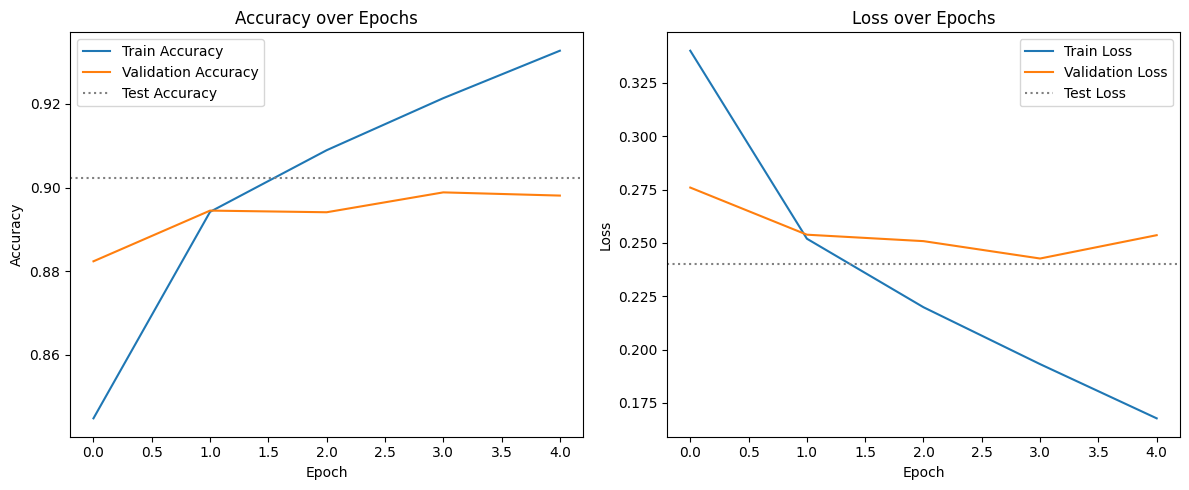

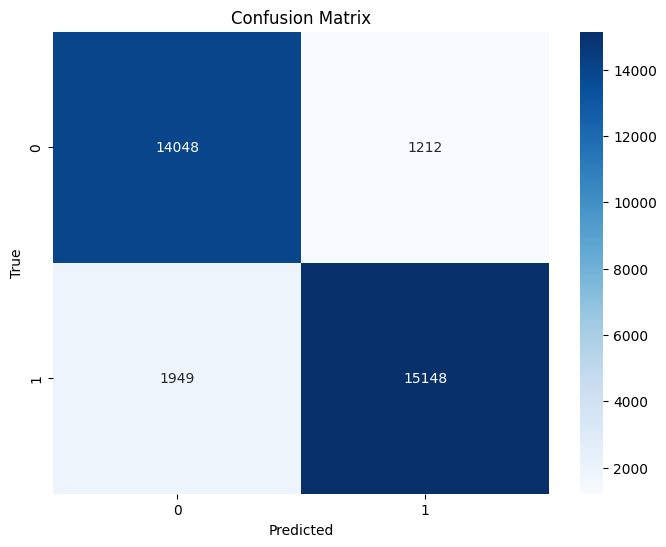

Precision: 0.9034
Recall: 0.9023
F1 Score: 0.9024


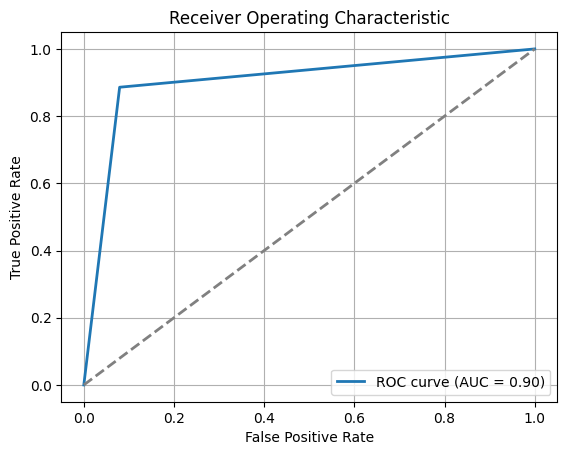

(array([0.        , 0.07942333, 1.        ]),
 array([0.        , 0.88600339, 1.        ]),
 0.9032900317217057)

In [88]:
import pickle

with open("base_results.pkl", "rb") as f:
    results_base = pickle.load(f)

train_acc_hist = results_base["train_acc_hist"]
train_loss_hist = results_base["train_loss_hist"]
val_acc_hist = results_base["val_acc_hist"]
val_loss_hist = results_base["val_loss_hist"]
test_acc_base = results_base["test_acc_base"]
test_loss_base = results_base["test_loss_base"]
true_labels = results_base["true_labels"]
pred_labels = results_base["pred_labels"]

display_results(train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, test_acc_base, test_loss_base, true_labels, pred_labels)
compute_metrics(true_labels, pred_labels)
plot_roc_curve(true_labels, pred_labels)

# Base Model + 0.1 Dropout Results

Training Accuracy: 87.48%
Training Loss: 0.2866
Validation Accuracy: 88.57%
Validation Loss: 0.2732
Test Accuracy: 90.30%
Test Loss: 0.2317


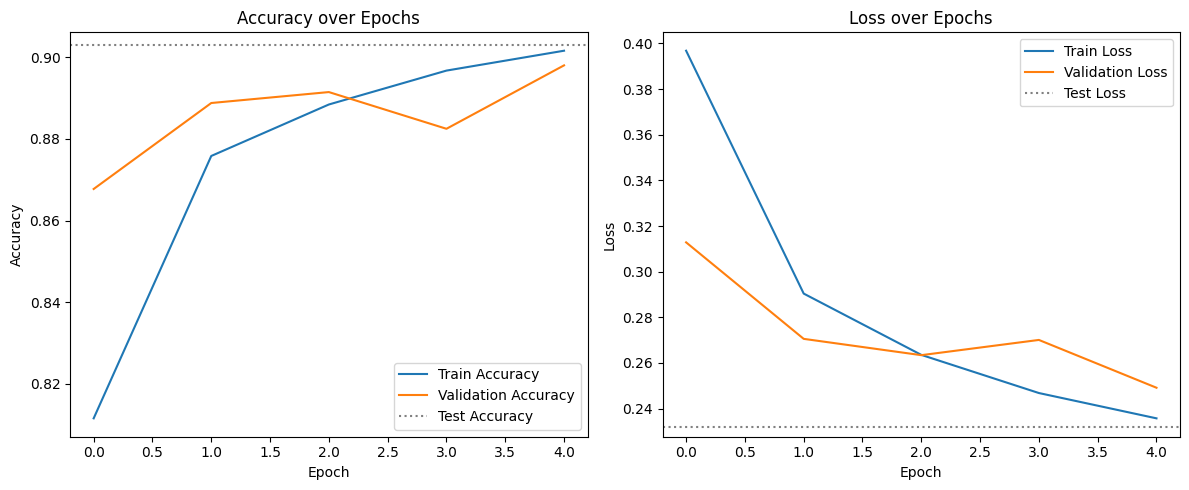

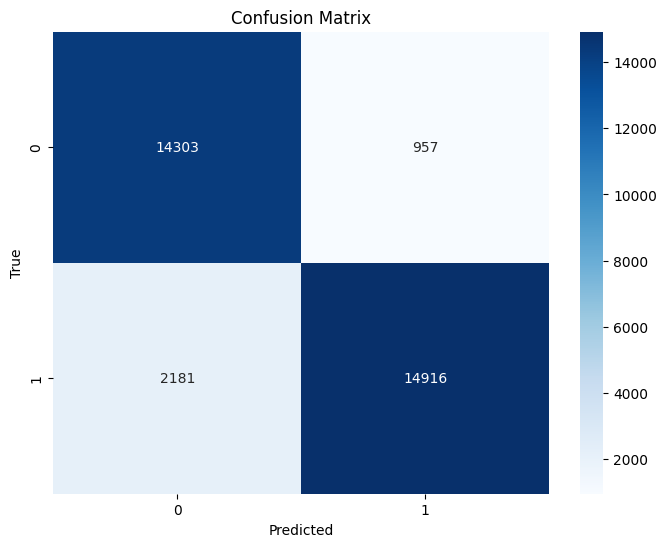

Precision: 0.9057
Recall: 0.9030
F1 Score: 0.9031


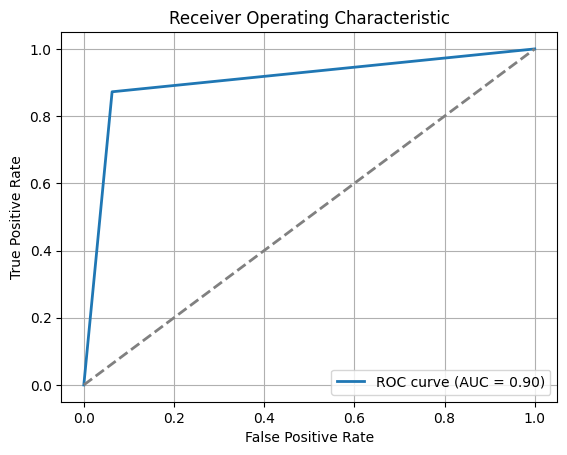

(array([0.        , 0.06271298, 1.        ]),
 array([0.        , 0.87243376, 1.        ]),
 0.904860392605265)

In [89]:
with open("results_dropout.pkl", "rb") as f:
    results_base = pickle.load(f)

train_acc_hist = results_base["train_acc_hist"]
train_loss_hist = results_base["train_loss_hist"]
val_acc_hist = results_base["val_acc_hist"]
val_loss_hist = results_base["val_loss_hist"]
test_acc_base = results_base["test_acc_base"]
test_loss_base = results_base["test_loss_base"]
true_labels = results_base["true_labels"]
pred_labels = results_base["pred_labels"]

display_results(train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, test_acc_base, test_loss_base, true_labels, pred_labels)
compute_metrics(true_labels, pred_labels)
plot_roc_curve(true_labels, pred_labels)

# Base Model + 0.1 Dropout + Schedular Results

Training Accuracy: 87.69%
Training Loss: 0.2812
Validation Accuracy: 88.89%
Validation Loss: 0.2685
Test Accuracy: 90.51%
Test Loss: 0.2324


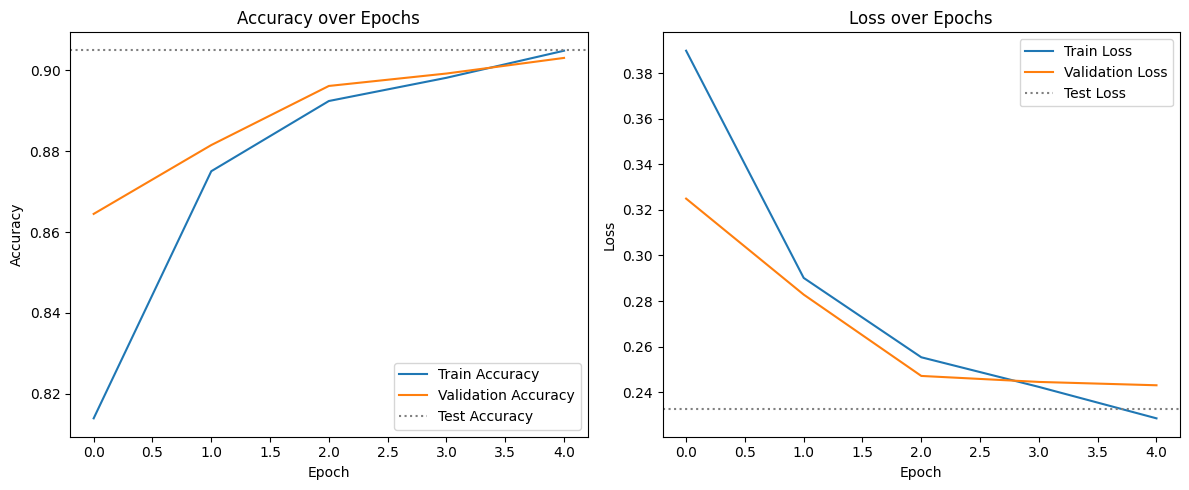

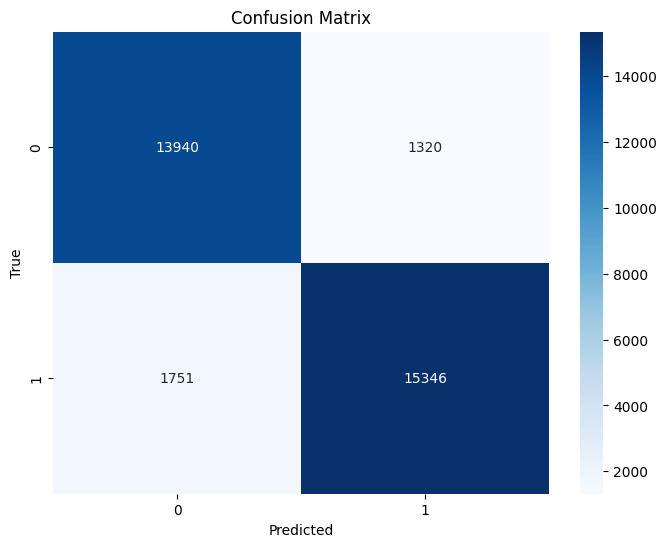

Precision: 0.9055
Recall: 0.9051
F1 Score: 0.9051


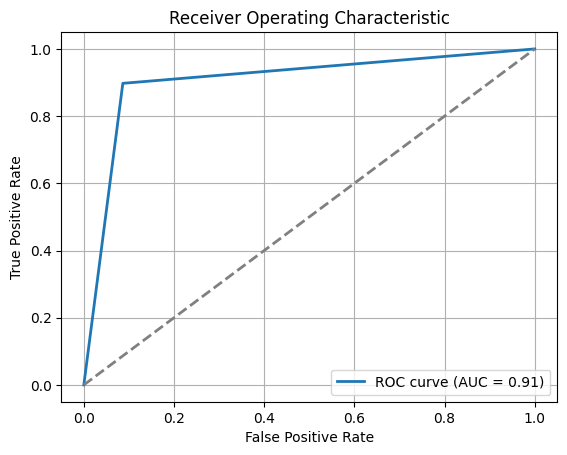

(array([0.        , 0.08650066, 1.        ]),
 array([0.        , 0.89758437, 1.        ]),
 0.9055418581095869)

In [90]:
with open("results_dropout_schedular.pkl", "rb") as f:
    results_base = pickle.load(f)

train_acc_hist = results_base["train_acc_hist"]
train_loss_hist = results_base["train_loss_hist"]
val_acc_hist = results_base["val_acc_hist"]
val_loss_hist = results_base["val_loss_hist"]
test_acc_base = results_base["test_acc_base"]
test_loss_base = results_base["test_loss_base"]
true_labels = results_base["true_labels"]
pred_labels = results_base["pred_labels"]

display_results(train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, test_acc_base, test_loss_base, true_labels, pred_labels)
compute_metrics(true_labels, pred_labels)
plot_roc_curve(true_labels, pred_labels)

# Base Model + 0.1 Dropout + Schedular + Early Stoping Results

Training Accuracy: 87.83%
Training Loss: 0.2801
Validation Accuracy: 89.33%
Validation Loss: 0.2630
Test Accuracy: 90.52%
Test Loss: 0.2343


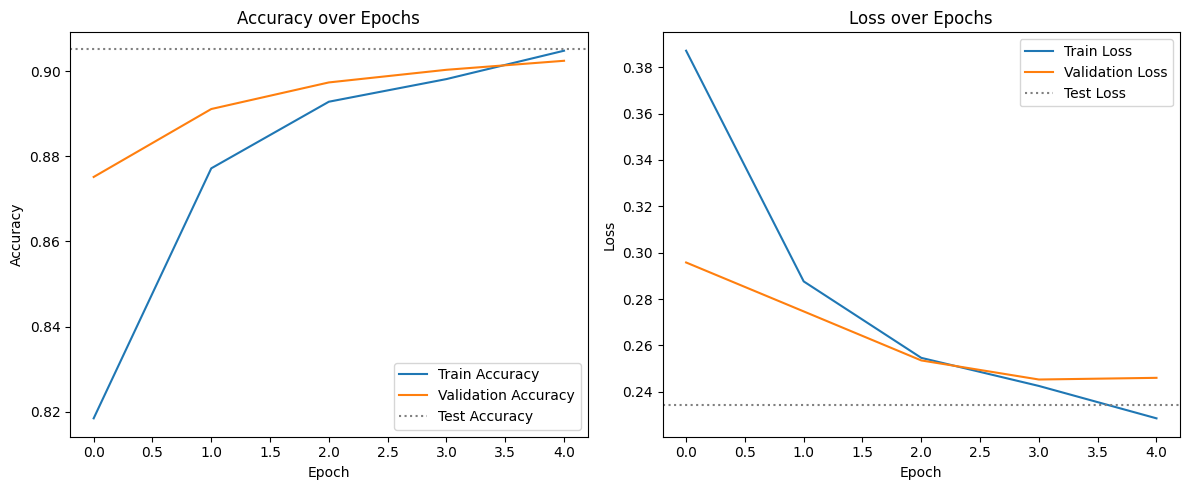

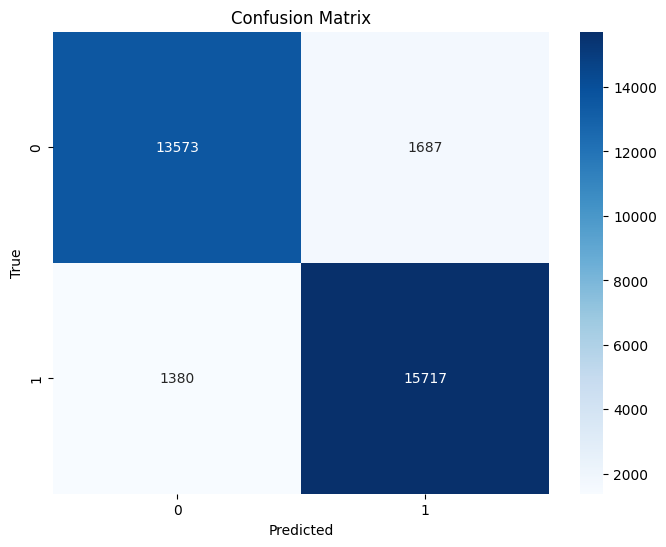

Precision: 0.9053
Recall: 0.9052
F1 Score: 0.9052


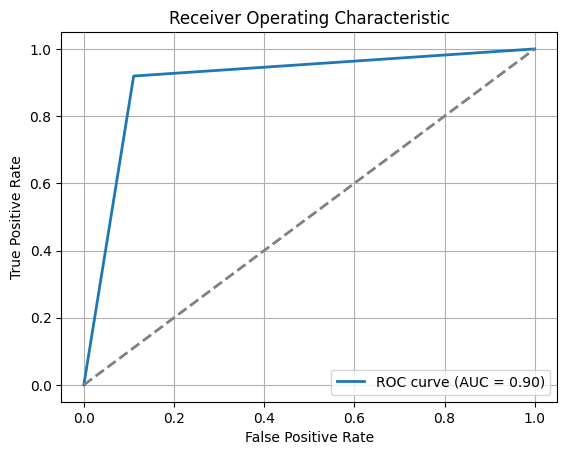

(array([0.        , 0.11055046, 1.        ]),
 array([0.        , 0.91928408, 1.        ]),
 0.9043668131057919)

In [91]:
with open("results_dropout_schedular_es.pkl", "rb") as f:
    results_base = pickle.load(f)

train_acc_hist = results_base["train_acc_hist"]
train_loss_hist = results_base["train_loss_hist"]
val_acc_hist = results_base["val_acc_hist"]
val_loss_hist = results_base["val_loss_hist"]
test_acc_base = results_base["test_acc_base"]
test_loss_base = results_base["test_loss_base"]
true_labels = results_base["true_labels"]
pred_labels = results_base["pred_labels"]

display_results(train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, test_acc_base, test_loss_base, true_labels, pred_labels)
compute_metrics(true_labels, pred_labels)
plot_roc_curve(true_labels, pred_labels)

2. Discuss how the optimization techniques helped to improve the performance of the model.

Dropout (0.1) helped reduce overfitting by preventing the model from relying too heavily on specific neurons. This is visible in the relatively small gap between training and validation accuracy.

The learning rate scheduler allowed the model to make larger steps early in training and smaller, more refined updates as training progressed. This stabilized validation loss and improved convergence.

Early stopping ensured that the model stopped training as soon as validation performance plateaued, preventing overfitting and saving training time.

The final test accuracy of 90.52%, paired with a low test loss of 0.2343, indicates that the model generalized well to unseen data.

All three techniques contributed to consistent, reliable performance across all splits (train, val, and test), as well as a strong F1 score (0.9052) and AUC (0.904).

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

| Metric                 | Value      |
|------------------------|------------|
| **Training Accuracy**  | 87.83%     |
| **Training Loss**      | 0.2801     |
| **Validation Accuracy**| 89.33%     |
| **Validation Loss**    | 0.2685     |
| **Test Accuracy**      | 90.52%     |
| **Test Loss**          | 0.2343     |

#### Short Analysis

- The training accuracy and loss indicate the model learned the training data well without overfitting.
- Validation metrics are closely aligned with training metrics, showing that the model generalizes well and is not overfitting.
- The test accuracy (90.52%) is slightly higher than both training and validation accuracy, which suggests that the model is stable and performs consistently on unseen data.
- The consistently low loss across all datasets supports the effectiveness of the training process and confirms that the model's predictions are confident and well-calibrated.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

  - [Yelp Review Polarity Dataset (from Xiang Zhang)]
    This dataset was used for binary sentiment classification based on Yelp reviews. The labels were mapped to positive and negative sentiment classes.
  - [PyTorch Official Transformer Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)  
    For understanding and implementing the Transformer encoder using PyTorch modules.
  - [PyTorch Official Tutorials](https://pytorch.org/tutorials/)  
    For reference on model building, training loops, and using `nn.TransformerEncoder`.
  - [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/)  
    Used for generating plots such as accuracy/loss curves and confusion matrices.
  - [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)  
    For metrics like precision, recall, F1-score, and ROC AUC.


6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| dshrisai  | Step 1 |  50 |
| sumanman  | Step 1 |  50 |
|  dshrisai | Step 2 |  50 |
| sumanman  | Step 2 |  50 |
|  dshrisai | Step 3 |  50 |
| sumanman  | Step 3 |  50 |
| dshrisai  | Step 4 |  50 |
| sumanman  | Step 4 |  50 |

| Both  | **Total** | 100  |